## Potential Condidates Project

### Background:

As a talent sourcing and management company, we are interested in finding talented individuals for sourcing these candidates to technology companies. Finding talented candidates is not easy, for several reasons. The first reason is one needs to understand what the role is very well to fill in that spot, this requires understanding the client’s needs and what they are looking for in a potential candidate. The second reason is one needs to understand what makes a candidate shine for the role we are in search for. Third, where to find talented individuals is another challenge.

The nature of our job requires a lot of human labor and is full of manual operations. Towards automating this process we want to build a better approach that could save us time and finally help us spot potential candidates that could fit the roles we are in search for. Moreover, going beyond that for a specific role we want to fill in we are interested in developing a machine learning powered pipeline that could spot talented individuals, and rank them based on their fitness.

We are right now semi-automatically sourcing a few candidates, therefore the sourcing part is not a concern at this time but we expect to first determine best matching candidates based on how fit these candidates are for a given role. We generally make these searches based on some keywords such as “full-stack software engineer”, “engineering manager” or “aspiring human resources” based on the role we are trying to fill in. These keywords might change, and you can expect that specific keywords will be provided to you.

Assuming that we were able to list and rank fitting candidates, we then employ a review procedure, as each candidate needs to be reviewed and then determined how good a fit they are through manual inspection. This procedure is done manually and at the end of this manual review, we might choose not the first fitting candidate in the list but maybe the 7th candidate in the list. If that happens, we are interested in being able to re-rank the previous list based on this information. This supervisory signal is going to be supplied by starring the 7th candidate in the list. Starring one candidate actually sets this candidate as an ideal candidate for the given role. Then, we expect the list to be re-ranked each time a candidate is starred.

### Data Description:

The data is proprietary of a talent and sourcing company and is made of the following features:<br>
* `id` - unique identifier for candidate (numeric) <br>
* `job_title` - job title for candidate (text) <br>
* `location` - geographical location for candidate (text) <br>
* `connections` - number of connections candidate has, 500+ means over 500 (text) <br>

`target` - Based on the role keywords (“Aspiring human resources” or “seeking human resources”) provided, determine how fit the candidate is for the role?

### Goal:

Phase 1: In this phase, we will rank suitable candidates based on the queries provided. Machine Learniing model is developed that will compare the similarities between the given query and candidate's job title and rank them accordingly.

Phase 2: Based on the information provided by the HR regarding suitable candidates, the candidates are re-ranked using a neural network. The goal of this phase is to ensure that human feedback is considered to rank the candidates.

### Import Modules and Data

In [1]:
import pandas as pd
import numpy as np
import os
import random
from itertools import combinations

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.spatial.distance import cosine
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split

import tensorflow as tf

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

from IPython.display import display
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
# Random seeding to ensure results are reproduced
seed_value=42
os.environ['PYTHONHASHSEED']=str(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

In [3]:
df = pd.read_csv("dataset.csv", sep=",")
print(df.shape)
df.head()

(104, 5)


,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB


In [5]:
# Define helper functions and classes

def pre_processing(text_to_preprocess):
    """
    Lemmatize, remove stopwords digits and special characters, replace abbreviations, returns the processed text 
    """
    cleaned_text = []
    lemmatizer = WordNetLemmatizer()
    for text in text_to_preprocess:
        processed_text = ' '.join([word.lower() for word in word_tokenize(text)])
        processed_text = ''.join([word.translate(str.maketrans('', '', string.punctuation)) for word in processed_text])
        processed_text = ''.join([i for i in processed_text if not i.isdigit()])
        processed_text = ' '.join([word for word in processed_text.split() if not word in stopwords.words('english')])
        processed_text = ' '.join( [w for w in processed_text.split() if len(w)>1])
        processed_text = [lemmatizer.lemmatize(word) for word in nltk.word_tokenize(processed_text)]
        processed_text = ' '.join([i for i in processed_text])
        cleaned_text.append(processed_text)
    return cleaned_text

def clean_phrase(phrase):
    lemmatizer = WordNetLemmatizer()
    X = [lemmatizer.lemmatize(word) for word in word_tokenize(phrase.lower())]
    X = ' '.join([i for i in X])
    return X


def check_similarity(column_name, embeddings, X_search):
    copy_df = df.copy()

    score_list = []
    for i in range(len(df)):
        score_list.append(1 - cosine(embeddings[i], X_search))
    
    copy_df[column_name] = score_list
    display(copy_df.sort_values(by = column_name, ascending=False, ignore_index=True).head(10))
    return score_list
    
def generate_word_cloud(column):
    job_text = " ".join(item for item in column)
    plt.figure(figsize=(10, 5))
    word_cloud = WordCloud(max_font_size=50, max_words=100, 
                           collocations=False, background_color="#b3cccc",).generate(job_text)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
def plot_loss(data):
    plt.title("Loss v/s Epochs")
    plt.plot(data['loss'], label='Training_loss')
    plt.plot(data['val_loss'], label='Validation_loss')
    plt.xlabel("Training Epochs")
    plt.ylabel("Loss")
    plt.show()
    
class Ranknet(tf.keras.Model):
    
    def __init__(self):
        super().__init__()
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Input(shape=(768)))
        self.model.add(tf.keras.layers.Dense(800, activation='linear', name='layer_1'))
        self.model.add(tf.keras.layers.Dropout(rate=0.2, name='dropput_layer_1'))
        self.model.add(tf.keras.layers.Dense(1600, activation=tf.nn.leaky_relu, name='layer_2'))
        self.model.add(tf.keras.layers.Dropout(rate=0.2, name='dropput_layer_2'))
        self.model.add(tf.keras.layers.Dense(400, activation=tf.nn.leaky_relu, name='layer_3'))
        self.model.add(tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer'))
        
    def call(self, docs):
        doc1, doc2 = docs
        s1 = self.model(doc1)
        s2 = self.model(doc2)
        output = tf.nn.sigmoid(s1 - s2)
        return output
        
    def predict(self, input_):
        s = self.model(input_)
        return s
    
    def build_graph(self):
        X = [ tf.keras.layers.Input(shape=(768)), tf.keras.layers.Input(shape=(768))]
        return tf.keras.Model(inputs=X,outputs=self.forward(X))

### Data Preparation and Analysis

In [6]:
# Columns that are not required are removed
df.drop(['fit'], axis=1, inplace=True)
df['connection'] = df['connection'].replace(['500+ '], '500')
print(df.shape)
df.head()

(104, 4)


,id,job_title,location,connection
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44
3,4,People Development Coordinator at Ryan,"Denton, Texas",500
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500


**Analysis of candidates based on location:**

Total Unique locations:  41


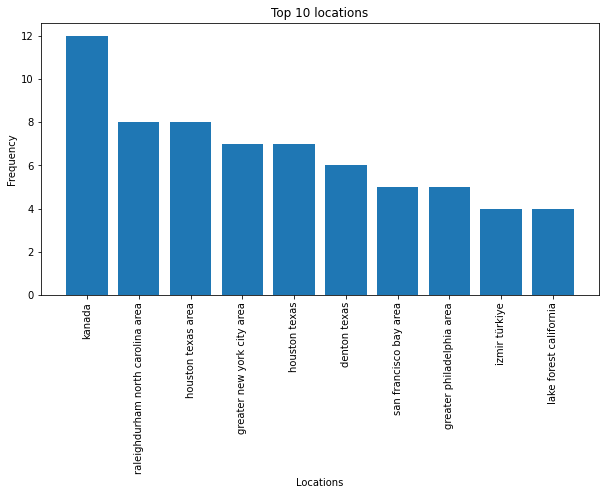

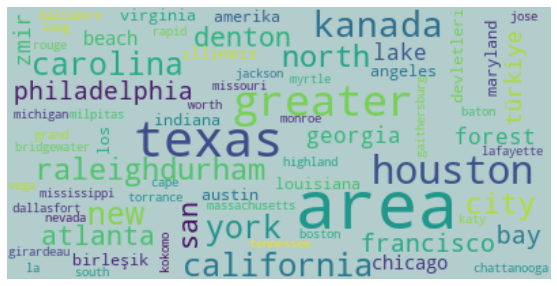

In [7]:
df['location'] = pre_processing(df['location'])
print("Total Unique locations: ", len(df.location.value_counts()))

# Top 10 locations
plt.figure(figsize=(10, 5))
plt.bar(df.location.value_counts().index[: 10], df.location.value_counts()[: 10])
plt.xticks(rotation=90)
plt.title("Top 10 locations")
plt.xlabel("Locations")
plt.ylabel("Frequency")
plt.show()
    
generate_word_cloud(df['location'])

From the word plot and the frequency distribution, we observe that majority of job titles listed belong to Houston, California, atlanta and New York.

**Analysis of candidates' job titles:** <br>

We perform the following pre-processing steps on the text data in our dataset
* Lemmatization
* Stop word removal
* Special characters removal
* Tokenization
* Abbreviations are replaced with their original values

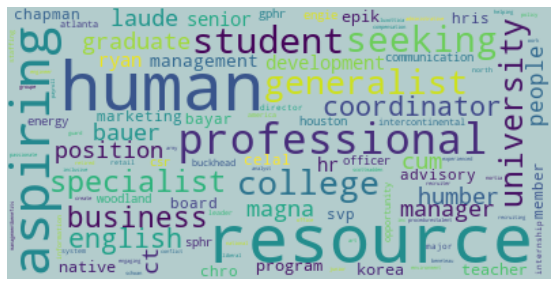

Top 10 frequently used words:


,Words,Frequency
9,human,63
10,resource,63
8,aspiring,35
11,professional,21
29,student,16
34,seeking,15
31,generalist,14
2,college,14
27,university,12
28,specialist,12


In [8]:
df['job_title'] = pre_processing(df['job_title'])
#print("Total Unique locations: ", len(df.location.value_counts()))

generate_word_cloud(df['job_title'])

word_dict = {}

for val in df['job_title']:
    for word in val.split(" "):
        if word not in word_dict:
            word_dict[word] = 1
        else:
            word_dict[word] = word_dict[word] + 1
            
print("Top 10 frequently used words:")

pd.DataFrame({'Words': word_dict.keys(), 
              'Frequency': word_dict.values()}).sort_values(by=['Frequency'], ascending=False).head(10)

From the word plot, we observe that most common words in job titles are human, resource, professional.

**Dataset Preparation:** Duplicate rows are removed after the pre-processing steps.

In [9]:
df = df[~df.drop(["id"], axis=1).duplicated()]
df.reset_index(inplace=True, drop=True)
print("Dataset Shape: ", df.shape)
display(df.head())

phrase_one = clean_phrase("Aspiring human resources")
print("Pre-processed query1: ", phrase_one)
phrase_two = clean_phrase("Seeking human resources")
print("Pre-processed query2: ", phrase_two)

Dataset Shape:  (53, 4)


,id,job_title,location,connection
0,1,ct bauer college business graduate magna cum l...,houston texas,85
1,2,native english teacher epik english program korea,kanada,500
2,3,aspiring human resource professional,raleighdurham north carolina area,44
3,4,people development coordinator ryan,denton texas,500
4,5,advisory board member celal bayar university,i̇zmir türkiye,500


Pre-processed query1:  aspiring human resource
Pre-processed query2:  seeking human resource


In [10]:
for i in range(53):
    print(df['job_title'][i])

ct bauer college business graduate magna cum laude aspiring human resource professional
native english teacher epik english program korea
aspiring human resource professional
people development coordinator ryan
advisory board member celal bayar university
aspiring human resource specialist
student humber college aspiring human resource generalist
hr senior specialist
seeking human resource hris generalist position
student chapman university
svp chro marketing communication csr officer engie houston woodland energy gphr sphr
human resource coordinator intercontinental buckhead atlanta
aspiring human resource management student seeking internship
seeking human resource opportunity
experienced retail manager aspiring human resource professional
human resource staffing recruiting professional
human resource specialist luxottica
director human resource north america groupe beneteau
retired army national guard recruiter office manager seeking position human resource
human resource generalist

### Phase 1:

The goal of this phase is to build a model that provides the similarity score between job titles and queries. We will generate embeddings from the dataset using the following embedding techniques.

* TF-TDF cosine similarity
* BERT pre-trained model cosine similarity

We will rank the job titles based on the similarity scores obtained for different embedding techniques. We will select the best performing model from these techniques and use that for the next phase

#### a. TF-TDF cosine similarity

TF-TDF matrix is generated for the dataset, similarly TF-IDF term for the queries are also generated. Cosine similarity score is used as the similarity metric to find job titles similar to the given queries.

In [11]:
tf_idf = TfidfVectorizer().fit(df.job_title)
tf_idf_embeddings = tf_idf.transform(df.job_title)

# tf_idf.get_feature_names()
tf_idf_embeddings = tf_idf_embeddings.toarray()
print(tf_idf_embeddings.shape)

X_search_one = tf_idf.transform([phrase_one]).toarray()
X_search_two = tf_idf.transform([phrase_two]).toarray()

print("Top 10 candidates for the job title:", phrase_one)
check_similarity("tf_idf_cosine_sim_query1", tf_idf_embeddings, X_search_one)
print("Top 10 candidates for the job title:", phrase_two)
check_similarity("tf_idf_cosine_sim_query2", tf_idf_embeddings, X_search_two)
print("")

(53, 176)
Top 10 candidates for the job title: aspiring human resource


,id,job_title,location,connection,tf_idf_cosine_sim_query1
0,3,aspiring human resource professional,raleighdurham north carolina area,44,0.773149
1,97,aspiring human resource professional,kokomo indiana area,71,0.773149
2,6,aspiring human resource specialist,greater new york city area,1,0.682828
3,73,aspiring human resource manager seeking intern...,houston texas area,7,0.623759
4,27,aspiring human resource management student see...,houston texas area,500,0.440969
5,72,business management major aspiring human resou...,monroe louisiana area,5,0.438591
6,74,human resource professional,greater boston area,16,0.422027
7,66,experienced retail manager aspiring human reso...,austin texas area,57,0.412112
8,7,student humber college aspiring human resource...,kanada,61,0.397799
9,100,aspiring human resource manager graduating may...,cape girardeau missouri,103,0.383139


Top 10 candidates for the job title: seeking human resource


,id,job_title,location,connection,tf_idf_cosine_sim_query2
0,99,seeking human resource position,la vega nevada area,48,0.703142
1,28,seeking human resource opportunity,chicago illinois,390,0.680080
2,73,aspiring human resource manager seeking intern...,houston texas area,7,0.638222
3,10,seeking human resource hris generalist position,greater philadelphia area,500,0.466750
4,27,aspiring human resource management student see...,houston texas area,500,0.466560
5,74,human resource professional,greater boston area,16,0.398880
6,100,aspiring human resource manager graduating may...,cape girardeau missouri,103,0.392023
7,94,seeking human resource opportunity open travel...,amerika birleşik devletleri,415,0.374791
8,75,nortia staffing seeking human resource payroll...,san jose california,500,0.355488
9,3,aspiring human resource professional,raleighdurham north carolina area,44,0.326290


From the results, we can observe that we get relevant results from the tf-idf cosine similarity approach for both queries. However, we will look at other techniques which can give better similarity score.

#### b. BERT pre-trained model cosine similarity

Pre-trained BERT model is used to generate embeddings and cosine similarity is used to find similar job titles based on the queries.

In [12]:
# BERT Model

s_embedder = SentenceTransformer('all-mpnet-base-v2')
# s_embedder = SentenceTransformer('bert-base-nli-mean-tokens')
bert_embeddings = s_embedder.encode(df.job_title)

print(bert_embeddings.shape)

X_search_one = s_embedder.encode(phrase_one)
X_search_two = s_embedder.encode(phrase_two)

print("Top 10 candidates for the job title:", phrase_one)
bert_similarity_query1 = check_similarity("BERT_cosine_sim_query1", bert_embeddings, X_search_one)
print("Top 10 candidates for the job title:", phrase_two)
bert_similarity_query2 = check_similarity("BERT_cosine_sim_query2", bert_embeddings, X_search_two)

(53, 768)
Top 10 candidates for the job title: aspiring human resource


,id,job_title,location,connection,BERT_cosine_sim_query1
0,3,aspiring human resource professional,raleighdurham north carolina area,44,0.880906
1,97,aspiring human resource professional,kokomo indiana area,71,0.880906
2,6,aspiring human resource specialist,greater new york city area,1,0.877840
3,74,human resource professional,greater boston area,16,0.754004
4,82,aspiring human resource professional energetic...,austin texas area,174,0.729662
5,67,human resource staffing recruiting professional,jackson mississippi area,500,0.717234
6,72,business management major aspiring human resou...,monroe louisiana area,5,0.705096
7,73,aspiring human resource manager seeking intern...,houston texas area,7,0.701774
8,7,student humber college aspiring human resource...,kanada,61,0.701407
9,76,aspiring human resource professional passionat...,new york new york,212,0.693467


Top 10 candidates for the job title: seeking human resource


,id,job_title,location,connection,BERT_cosine_sim_query2
0,28,seeking human resource opportunity,chicago illinois,390,0.881616
1,99,seeking human resource position,la vega nevada area,48,0.838536
2,67,human resource staffing recruiting professional,jackson mississippi area,500,0.810193
3,6,aspiring human resource specialist,greater new york city area,1,0.728420
4,10,seeking human resource hris generalist position,greater philadelphia area,500,0.712926
5,74,human resource professional,greater boston area,16,0.705744
6,73,aspiring human resource manager seeking intern...,houston texas area,7,0.685609
7,3,aspiring human resource professional,raleighdurham north carolina area,44,0.672488
8,97,aspiring human resource professional,kokomo indiana area,71,0.672488
9,101,human resource generalist loparex,raleighdurham north carolina area,500,0.661799


From the results, we can observe that we get relevant results from the BERT pre-trained model cosine similarity for both queries.

### Phase 2:

The BERT model embeddings are identified as the best way to rank the candidates. HR is given an option to bookmark certain candidates from the list of candidates. A new fitness score based on the previous similarity score and user selection is calculated and a neural network is developed that will re-rank the models based on the fitness score.

**Re-ranking candidates for query1:**

In [13]:
df['Fitness_score_query1'] = bert_similarity_query1
usr_selection = input("Would you like to bookmark certain candidates for query1: ")
if usr_selection == 'yes':
    star_list = input("List all the candidates to bookmark (Separated by a comma): ")
    for i in star_list.split(" "):
        df.loc[df['id']==int(i), 'Fitness_score_query1'] = 1         
            
df.head(10)

Would you like to bookmark certain candidates for query1: yes
List all the candidates to bookmark (Separated by a comma): 1 3 6


,id,job_title,location,connection,Fitness_score_query1
0,1,ct bauer college business graduate magna cum l...,houston texas,85,1.000000
1,2,native english teacher epik english program korea,kanada,500,0.309570
2,3,aspiring human resource professional,raleighdurham north carolina area,44,1.000000
3,4,people development coordinator ryan,denton texas,500,0.529167
4,5,advisory board member celal bayar university,i̇zmir türkiye,500,0.356170
5,6,aspiring human resource specialist,greater new york city area,1,1.000000
6,7,student humber college aspiring human resource...,kanada,61,0.701407
7,8,hr senior specialist,san francisco bay area,500,0.603526
8,10,seeking human resource hris generalist position,greater philadelphia area,500,0.574739
9,11,student chapman university,lake forest california,2,0.343272


**RankNet:**

We will use a pairwise learning to rank (LTR) model called ranknet to re-rank the candidates. The model takes input pair of documents as the input and learns to rank according to the preferences. We will create two separate documents for comparison by sampling the dataset to ensure randomness. The difference between the fitness scores of the pair of candidates is used to train ranknet to make predictions.

In [14]:
random_row_1 = df.sample(n=100, replace=True)
random_row_2 = df.sample(n=100, replace=True)

doc1 = s_embedder.encode(list(random_row_1['job_title']))
doc2 = s_embedder.encode(list(random_row_2['job_title']))

y1 = list(random_row_1['Fitness_score_query1'])
y2 = list(random_row_2['Fitness_score_query1'])

# Create a list of all the available combinations between the two documents
pairs = list(combinations(range(100), 2))

# X_query11 and X_query12 store the respective embeddings for each documents
X_query11 = []
X_query12 = []

# Store the target values
output_query1 = []

for idx in pairs:
    i, j = idx
    X_query11.append(doc1[i])
    X_query12.append(doc2[j])
    if (y1[i] == y2[j]):
        output_query1.append(0.5)
    elif (y1[i] > y2[j]):
        output_query1.append(1.0)
    else:
        output_query1.append(0.0)
        
# Convert the list into numpy arrays
X_query11 = np.array(X_query11)
X_query12 = np.array(X_query12)
output_query1 = np.array(output_query1)

# Perform Test Train split to get validation data 
x_train_11, x_val_11, x_train_12, x_val_12, y_train, y_val = train_test_split(
    X_query11, X_query12, output_query1, test_size=0.2)

In [15]:
rank_net = Ranknet()

# Early Stopping criteria
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)

# Model Compilation step
rank_net.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), 
                loss='binary_crossentropy')

# Model Training
trained_ranknet = rank_net.fit([x_train_11, x_train_12], y_train, epochs=2000, 
                      validation_data=([x_val_11, x_val_12], y_val),
                              callbacks =[early_stopping], verbose=0)

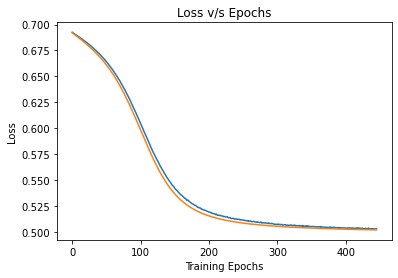

In [16]:
plot_loss(trained_ranknet.history)

In [17]:
df['Fitness_score_query1'] = list(rank_net.predict(bert_embeddings).numpy())
display(df.head(10))

,id,job_title,location,connection,Fitness_score_query1
0,1,ct bauer college business graduate magna cum l...,houston texas,85,[0.9889941]
1,2,native english teacher epik english program korea,kanada,500,[0.015290493]
2,3,aspiring human resource professional,raleighdurham north carolina area,44,[0.99877304]
3,4,people development coordinator ryan,denton texas,500,[0.44157353]
4,5,advisory board member celal bayar university,i̇zmir türkiye,500,[0.009344743]
5,6,aspiring human resource specialist,greater new york city area,1,[0.99852896]
6,7,student humber college aspiring human resource...,kanada,61,[0.98910326]
7,8,hr senior specialist,san francisco bay area,500,[0.9630217]
8,10,seeking human resource hris generalist position,greater philadelphia area,500,[0.9681876]
9,11,student chapman university,lake forest california,2,[0.0093388995]


#### Top 20 results for the query 'aspiring human resource':

In [18]:
display(df.sort_values(by = 'Fitness_score_query1', ascending=False, ignore_index=True).head(20))

,id,job_title,location,connection,Fitness_score_query1
0,97,aspiring human resource professional,kokomo indiana area,71,[0.99877304]
1,3,aspiring human resource professional,raleighdurham north carolina area,44,[0.99877304]
2,6,aspiring human resource specialist,greater new york city area,1,[0.99852896]
3,66,experienced retail manager aspiring human reso...,austin texas area,57,[0.9980019]
4,72,business management major aspiring human resou...,monroe louisiana area,5,[0.99761397]
5,73,aspiring human resource manager seeking intern...,houston texas area,7,[0.99660337]
6,88,human resource management major,milpitas california,18,[0.99531347]
7,76,aspiring human resource professional passionat...,new york new york,212,[0.9946238]
8,74,human resource professional,greater boston area,16,[0.9945835]
9,82,aspiring human resource professional energetic...,austin texas area,174,[0.9937571]


The candidates are re-ranked based on the fitness score and user preference

**Re-ranking candidates for query2:**

In [19]:
df['Fitness_score_query2'] = bert_similarity_query2
usr_selection = input("Would you like to bookmark certain candidates for query2: ")
if usr_selection == 'yes':
    star_list = input("List all the candidates to bookmark (Separated by a comma): ")
    for i in star_list.split(" "):
        df.loc[df['id']==int(i), 'Fitness_score_query2'] = 1         
            
df.head(10)

Would you like to bookmark certain candidates for query2: yes
List all the candidates to bookmark (Separated by a comma): 8 10 27


,id,job_title,location,connection,Fitness_score_query1,Fitness_score_query2
0,1,ct bauer college business graduate magna cum l...,houston texas,85,[0.9889941],0.509758
1,2,native english teacher epik english program korea,kanada,500,[0.015290493],0.252325
2,3,aspiring human resource professional,raleighdurham north carolina area,44,[0.99877304],0.672488
3,4,people development coordinator ryan,denton texas,500,[0.44157353],0.505585
4,5,advisory board member celal bayar university,i̇zmir türkiye,500,[0.009344743],0.298487
5,6,aspiring human resource specialist,greater new york city area,1,[0.99852896],0.728420
6,7,student humber college aspiring human resource...,kanada,61,[0.98910326],0.640132
7,8,hr senior specialist,san francisco bay area,500,[0.9630217],1.000000
8,10,seeking human resource hris generalist position,greater philadelphia area,500,[0.9681876],1.000000
9,11,student chapman university,lake forest california,2,[0.0093388995],0.271468


In [20]:
random_row_1 = df.sample(n=100, replace=True)
random_row_2 = df.sample(n=100, replace=True)

doc1 = s_embedder.encode(list(random_row_1['job_title']))
doc2 = s_embedder.encode(list(random_row_2['job_title']))

y1 = list(random_row_1['Fitness_score_query2'])
y2 = list(random_row_2['Fitness_score_query2'])

# Create a list of all the available combinations between the two documents
pairs = list(combinations(range(100), 2))

# X_query11 and X_query12 store the respective embeddings for each documents
X_query21 = []
X_query22 = []

# Store the target values
output_query2 = []

for idx in pairs:
    i, j = idx
    X_query21.append(doc1[i])
    X_query22.append(doc2[j])
    if (y1[i] == y2[j]):
        output_query2.append(0.5)
    elif (y1[i] > y2[j]):
        output_query2.append(1.0)
    else:
        output_query2.append(0.0)
        
# Convert the list into numpy arrays
X_query21 = np.array(X_query21)
X_query22 = np.array(X_query22)
output_query2 = np.array(output_query2)

# Perform Test Train split to get validation data 
x_train_21, x_val_21, x_train_22, x_val_22, y_train2, y_val2 = train_test_split(
    X_query21, X_query22, output_query2, test_size=0.2)

In [21]:
rank_net = Ranknet()

# Early Stopping criteria
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)

# Model Compilation step
rank_net.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), 
                loss='binary_crossentropy')

# Model Training
trained_ranknet = rank_net.fit([x_train_21, x_train_22], y_train2, epochs=2000, 
                      validation_data=([x_val_21, x_val_22], y_val2),
                              callbacks =[early_stopping], verbose=0)

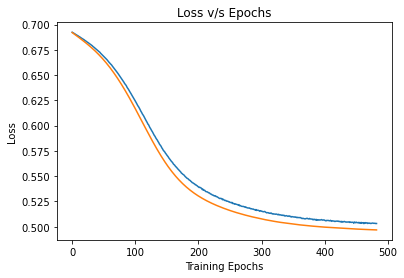

In [22]:
plot_loss(trained_ranknet.history)

In [23]:
df['Fitness_score_query2'] = list(rank_net.predict(bert_embeddings).numpy())
display(df.head(10))

,id,job_title,location,connection,Fitness_score_query1,Fitness_score_query2
0,1,ct bauer college business graduate magna cum l...,houston texas,85,[0.9889941],[0.07970462]
1,2,native english teacher epik english program korea,kanada,500,[0.015290493],[0.0042878147]
2,3,aspiring human resource professional,raleighdurham north carolina area,44,[0.99877304],[0.98735666]
3,4,people development coordinator ryan,denton texas,500,[0.44157353],[0.08898964]
4,5,advisory board member celal bayar university,i̇zmir türkiye,500,[0.009344743],[0.003954976]
5,6,aspiring human resource specialist,greater new york city area,1,[0.99852896],[0.99498063]
6,7,student humber college aspiring human resource...,kanada,61,[0.98910326],[0.75662136]
7,8,hr senior specialist,san francisco bay area,500,[0.9630217],[0.9884024]
8,10,seeking human resource hris generalist position,greater philadelphia area,500,[0.9681876],[0.9930342]
9,11,student chapman university,lake forest california,2,[0.0093388995],[0.005431305]


#### Top 20 results for the query 'seeking human resource':

In [24]:
display(df.sort_values(by = 'Fitness_score_query2', ascending=False, ignore_index=True).head(20))

,id,job_title,location,connection,Fitness_score_query1,Fitness_score_query2
0,99,seeking human resource position,la vega nevada area,48,[0.9852043],[0.998941]
1,28,seeking human resource opportunity,chicago illinois,390,[0.9875575],[0.998044]
2,67,human resource staffing recruiting professional,jackson mississippi area,500,[0.9886605],[0.997694]
3,6,aspiring human resource specialist,greater new york city area,1,[0.99852896],[0.99498063]
4,73,aspiring human resource manager seeking intern...,houston texas area,7,[0.99660337],[0.9948863]
5,10,seeking human resource hris generalist position,greater philadelphia area,500,[0.9681876],[0.9930342]
6,66,experienced retail manager aspiring human reso...,austin texas area,57,[0.9980019],[0.99068385]
7,74,human resource professional,greater boston area,16,[0.9945835],[0.9896618]
8,8,hr senior specialist,san francisco bay area,500,[0.9630217],[0.9884024]
9,75,nortia staffing seeking human resource payroll...,san jose california,500,[0.40713552],[0.987499]
